In [1]:
from premise import *
import bw2io as bw
import bw2data
bw2data.projects.set_current("ecoinvent-3.10-cutoff")

In [2]:
clear_inventory_cache()

Inventory cache cleared!


In [3]:
ndb = NewDatabase(
    scenarios=[
        {"model":"image", "pathway":"SSP2-Base", "year":2060},
    ],
    source_db="ecoinvent-3.10.1-cutoff", # <-- name of the database in the BW2 project. Must be a string.
    source_version="3.10", # <-- version of ecoinvent. Can be "3.5", "3.6", "3.7" or "3.8". Must be a string.
    key="tUePmX_S5B8ieZkkM7WUU2CnO8SmShwmAeWK9x2rTFo=",
    biosphere_name="biosphere3",
    keep_imports_uncertainty=True
    
    #external_scenarios=[FE2050,]
    #use_multiprocessing=True,
    #system_model="consequential"
    # to be requested from the library maintainers if you want to use default scenarios included in `premise`
)

premise v.(2, 1, 8)
+------------------------------------------------------------------+
| Warning                                                          |
+------------------------------------------------------------------+
| Because some of the scenarios can yield LCI databases            |
| containing net negative emission technologies (NET),             |
| it is advised to account for biogenic CO2 flows when calculating |
| Global Warming potential indicators.                             |
| `premise_gwp` provides characterization factors for such flows.  |
| It also provides factors for hydrogen emissions to air.          |
|                                                                  |
| Within your bw2 project:                                         |
| from premise_gwp import add_premise_gwp                          |
| add_premise_gwp()                                                |
+------------------------------------------------------------------+
+-------------

In [4]:
ndb.update("renewables")

Processing scenarios for sector 'renewables': 100%|█| 1/1 [00:38<00:00

Done!



In [ ]:
ndb.write_superstructure_db_to_brightway()

In [5]:
ndb.write_db_to_brightway("wt test 12")

Write new database(s) to Brightway.
Running all checks...
Minor anomalies found: check the change report.
Title: Writing activities to SQLite3 database:
  Started: 03/09/2025 12:45:07
  Finished: 03/09/2025 12:45:31
  Total time elapsed: 00:00:24
  CPU %: 87.70
  Memory %: 13.45
Created database: wt test 12
Generate scenario report.
Report saved under /Users/romain/GitHub/premise-johanna/dev/export/scenario_report.
Generate change report.
Report saved under /Users/romain/GitHub/premise-johanna/dev.


In [5]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import fsolve
import scipy.integrate as integrate


def get_fleet_distribution(mean, lower_bound, upper_bound, skew_factor=1.0) -> dict:
    """
    Generates a binned bounded lognormal distribution with a given mean and integrates to 1.
    The bins are of width 1, making it a histogram-like distribution.

    Parameters:
        mean (float): The desired mean of the distribution.
        lower_bound (float): The lower boundary.
        upper_bound (float): The upper boundary.
        skew_factor (float): Factor to increase the skewness to the right.

    Returns:
        bin_edges (numpy.ndarray): Array of bin edges.
        binned_pdf (numpy.ndarray): Normalized probability density function per bin.
    """
    # Define a function to solve for the lognormal parameters
    def objective(lognorm_params):
        shape, log_scale = lognorm_params
        scale = np.exp(log_scale)
        dist = stats.lognorm(s=shape, scale=scale)
        expected_mean = dist.mean()
        expected_variance = dist.var()
        return [expected_mean - mean, expected_variance - (skew_factor * mean) ** 2]  # Increase variance to skew right

    # Initial guess: lognormal with standard deviation around log(mean)
    initial_guess = [1.0, np.log(mean)]
    shape_opt, log_scale_opt = fsolve(objective, initial_guess)

    # Create lognormal distribution with optimized parameters
    scale_opt = np.exp(log_scale_opt)
    dist = stats.lognorm(s=shape_opt, scale=scale_opt)

    # Define bin edges from lower to upper bound with step size of 1
    bin_edges = np.arange(lower_bound, upper_bound + 1, 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints for better visualization

    # Compute the unnormalized probability density function (PDF) for bin centers
    pdf = dist.pdf(bin_centers)

    # Compute normalization constant by integrating over the specified bounds
    normalization_factor, _ = integrate.quad(lambda t: dist.pdf(t), lower_bound, upper_bound)

    # Normalize the PDF so that the integral equals 1
    binned_pdf = pdf / normalization_factor

    return bin_edges, binned_pdf

bins, dist = get_fleet_distribution(10, 1, 21, skew_factor=0.4)
fleet_distribution = dict(zip(bins * 1000, dist))
print("avg", sum([k * v for k, v in fleet_distribution.items()]))
print(fleet_distribution)

avg 9252.325526998346
{1000: 9.656113134606049e-06, 2000: 0.0012762868917214657, 3000: 0.012190027542867425, 4000: 0.0399849380218887, 5000: 0.07605509572946943, 6000: 0.10561055169338188, 7000: 0.12047775568359141, 8000: 0.12072901781750486, 9000: 0.11070015849155303, 10000: 0.09534901926966258, 11000: 0.07851591242475144, 12000: 0.06257023342057053, 13000: 0.04867603091933017, 14000: 0.037199900963679304, 15000: 0.028059470916588822, 16000: 0.020963176758583002, 17000: 0.015553921953962286, 18000: 0.011484860306883237, 19000: 0.008453030373719873, 20000: 0.006209357062109141}


(array([9.65611313e-06, 1.27628689e-03, 1.21900275e-02, 3.99849380e-02,
        7.60550957e-02, 1.05610552e-01, 1.20477756e-01, 1.20729018e-01,
        1.10700158e-01, 9.53490193e-02, 7.85159124e-02, 6.25702334e-02,
        4.86760309e-02, 3.71999010e-02, 2.80594709e-02, 2.09631768e-02,
        1.55539220e-02, 1.14848603e-02, 8.45303037e-03, 6.20935706e-03]),
 array([ 1000.,  1950.,  2900.,  3850.,  4800.,  5750.,  6700.,  7650.,
         8600.,  9550., 10500., 11450., 12400., 13350., 14300., 15250.,
        16200., 17150., 18100., 19050., 20000.]),
 <BarContainer object of 20 artists>)

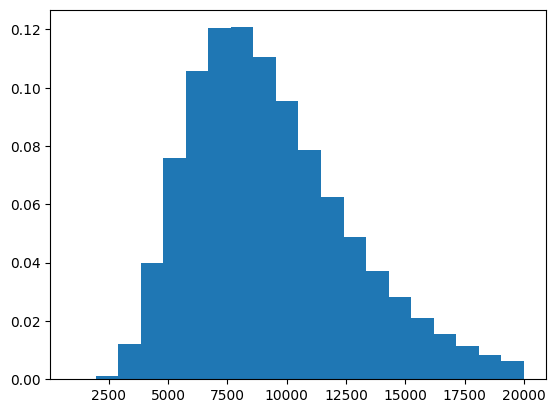

In [30]:
import matplotlib.pyplot as plt
plt.hist(fleet_distribution.keys(), weights=fleet_distribution.values(), bins=20)

In [11]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import fsolve
import scipy.integrate as integrate


def get_fleet_distribution(mean, lower_bound, upper_bound, skew_factor=1.0) -> dict:
    """
    Generates a binned bounded lognormal distribution with a given mean and integrates to 1.
    The bins are of width 1, making it a histogram-like distribution.

    Parameters:
        mean (float): The desired mean of the distribution.
        lower_bound (float): The lower boundary.
        upper_bound (float): The upper boundary.
        skew_factor (float): Factor to increase the skewness to the right.

    Returns:
        bin_edges (numpy.ndarray): Array of bin edges.
        binned_pdf (numpy.ndarray): Normalized probability density function per bin.
    """
    # Function to solve for lognormal parameters while ensuring the truncated mean equals `mean`
    def objective(lognorm_params):
        shape, log_scale = lognorm_params
        scale = np.exp(log_scale)
        dist = stats.lognorm(s=shape, scale=scale)

        # Compute the truncated mean over [lower_bound, upper_bound]
        normalization_factor, _ = integrate.quad(lambda x: dist.pdf(x), lower_bound, upper_bound)
        truncated_mean_numerator, _ = integrate.quad(lambda x: x * dist.pdf(x), lower_bound, upper_bound)
        truncated_mean = truncated_mean_numerator / normalization_factor  # Mean within truncation limits

        expected_variance = dist.var()

        return [truncated_mean - mean, expected_variance - (skew_factor * mean) ** 2]  # Adjust skew

    # Initial guess
    initial_guess = [1.0, np.log(mean)]
    shape_opt, log_scale_opt = fsolve(objective, initial_guess)

    # Create lognormal distribution with optimized parameters
    scale_opt = np.exp(log_scale_opt)
    dist = stats.lognorm(s=shape_opt, scale=scale_opt)

    # Define bin edges from lower to upper bound with step size of 1
    bin_edges = np.arange(lower_bound, upper_bound + 1, 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints for better visualization

    # Compute the unnormalized probability density function (PDF) for bin centers
    pdf = dist.pdf(bin_centers)

    # Compute normalization constant by integrating over the specified bounds
    normalization_factor, _ = integrate.quad(lambda t: dist.pdf(t), lower_bound, upper_bound)

    # Normalize the PDF so that the integral equals 1
    binned_pdf = pdf / normalization_factor

    return bin_edges, binned_pdf


# Test
bins, dist = get_fleet_distribution(2, 1, 21, skew_factor=0.5)
fleet_distribution = dict(zip(bins[:-1] * 1000, dist))  # Exclude last bin edge

# Validate mean
calculated_mean = sum([k * v for k, v in fleet_distribution.items()])
print("Calculated Mean:", calculated_mean)
print("Fleet Distribution:", fleet_distribution)


Calculated Mean: 1500.681162387045
Fleet Distribution: {1000: 0.6128691711218915, 2000: 0.17559144611813185, 3000: 0.06550181855992157, 4000: 0.0288250198382881, 5000: 0.014211446208396077, 6000: 0.007616044864997477, 7000: 0.0043517368602159915, 8000: 0.00261661923732428, 9000: 0.0016402167622335533, 10000: 0.0010644835012792021, 11000: 0.0007114788589945776, 12000: 0.00048773083375339995, 13000: 0.00034179543972470125, 14000: 0.0002442094258759925, 15000: 0.00017750706180297702, 16000: 0.0001310180788225453, 17000: 9.804808258509818e-05, 18000: 7.429654293134414e-05, 19000: 5.694157061534841e-05, 20000: 4.409578158665216e-05}


In [7]:
for ds in ndb.scenarios[0]["database"]:
    if ds["name"] == "market for biomass, used as fuel":
        print(ds["name"], ds["location"])
        for e in ds["exchanges"]:
            if e["type"] == "technosphere":
                print(e["name"], e["amount"], e["unit"])
        print()

market for biomass, used as fuel CAZ
market for wood chips, wet, measured as dry mass 0.7292617662157219 kilogram
supply of forest residue 0.27073823378427814 kilogram

market for biomass, used as fuel CHA
supply of forest residue 1.0 kilogram

market for biomass, used as fuel EUR
market for wood chips, wet, measured as dry mass 0.3627866341368478 kilogram
supply of forest residue 0.6372133658631522 kilogram

market for biomass, used as fuel IND
market for wood chips, dry, measured as dry mass 1.0 kilogram

market for biomass, used as fuel JPN
market for wood chips, dry, measured as dry mass 0.06843991001415911 kilogram
supply of forest residue 0.931560089985841 kilogram

market for biomass, used as fuel LAM
market for wood chips, dry, measured as dry mass 0.8558695875430907 kilogram
supply of forest residue 0.14413041245690933 kilogram

market for biomass, used as fuel MEA
market for wood chips, dry, measured as dry mass 0.02366156577686757 kilogram
supply of forest residue 0.97633843

In [ ]:
ndb.write_db_to_brightway()

In [13]:
list_trucks = []
for ds in bw2data.Database("cement 11"):
    if "unspecified" in ds["name"] and ds["unit"] == "ton kilometer":
        list_trucks.append(ds["name"])

for truck in set(sorted(list_trucks)):
    print(truck)

transport, freight, lorry, all sizes, EURO5 to generic market for transport, freight, lorry, unspecified
transport, freight, lorry, all sizes, EURO1 to generic market for transport, freight, lorry, unspecified
market for transport, freight, aircraft, unspecified
market group for transport, freight, lorry, unspecified
transport, freight, aircraft, all distances to generic market for transport, freight, aircraft, unspecified
transport, freight, lorry, all sizes, EURO2 to generic market for transport, freight, lorry, unspecified
transport, freight, lorry, 26t gross weight, unspecified powertrain, long haul
transport, freight, lorry, 40t gross weight, unspecified powertrain, long haul
transport, freight, lorry, all sizes, EURO4 to generic market for transport, freight, lorry, unspecified
transport, freight, lorry, all sizes, EURO6 to generic market for transport, freight, lorry, unspecified
transport, freight, lorry, all sizes, unregulated to generic market for transport, freight, lorry, u

In [ ]:
ndb.update()

Processing scenarios:   0%|                     | 0/1 [00:00<?, ?it/s]

In [5]:
ndb.generate_change_report()

Generate change report.
Report saved under /Users/romain/GitHub/premise/dev.


In [5]:
ndb.write_db_to_brightway(["truck 3", "truck 4"])

Write new database(s) to Brightway.
Running all checks...
Minor anomalies found: check the change report.


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:22


Title: Writing activities to SQLite3 database:
  Started: 08/21/2024 11:38:40
  Finished: 08/21/2024 11:39:03
  Total time elapsed: 00:00:22
  CPU %: 93.10
  Memory %: 13.49
Created database: truck 3
Running all checks...
Minor anomalies found: check the change report.


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:23


Title: Writing activities to SQLite3 database:
  Started: 08/21/2024 11:47:05
  Finished: 08/21/2024 11:47:29
  Total time elapsed: 00:00:23
  CPU %: 93.80
  Memory %: 13.50
Created database: truck 4
Generate scenario report.
Report saved under /Users/romain/Github/premise/dev/export/scenario_report.
Generate change report.
Report saved under /Users/romain/Github/premise/dev.


In [5]:
from premise.utils import load_database
for scenario in ndb.scenarios:
    scenario = load_database(scenario)

In [8]:
for ds in ndb.scenarios[0]["database"]:
    if ds["name"].startswith("transport, freight, lorry, all sizes, EURO5 to generic market for transport, freight, lorry, unspecified") and ds["location"] == "RER":
        print("ds", ds["name"], ds["reference product"])
        for e in ds["exchanges"]:
            print(e["name"], e["amount"], e["location"])

ds transport, freight, lorry, all sizes, EURO5 to generic market for transport, freight, lorry, unspecified transport, freight, lorry, unspecified
transport, freight, lorry, all sizes, EURO5 to generic market for transport, freight, lorry, unspecified 1.0 RER
transport, freight, lorry, unspecified, long haul 1 EUR


In [ ]:
for ds in ndb.scenarios[0]["database"]:
    for e in ds["exchanges"]:
        if e["name"] == "unsaturated hydrocarbons production, steam cracking operation, average" and e["reference product"] == "": 

In [6]:
print(len(ndb.scenarios[0]["database"]))
print(len(ndb.scenarios[1]["database"]))

34288
30578


In [7]:
print(len(ndb.scenarios[0]["database"]))
print(len(ndb.scenarios[1]["database"]))

41933
33590


In [11]:
import pandas as pd
for scenario in ndb.scenarios:
    df = pd.DataFrame(
        [
            [a["name"], a["reference product"], a["location"]] for a in scenario["database"]
            if [a["name"], a["reference product"], a["location"]] not in originals
        ]
    )
    df.to_excel(f"datasets {scenario['model']}.xlsx")

In [ ]:
ndb.write_db_to_brightway([
    "image - master 2",
    "remind - master 2"
])

Write new database(s) to Brightway.


In [10]:
import bw2data
bw2data.projects.set_current("new4")

In [11]:
preserve = [
    "biosphere3",
    "ecoinvent 3.9.1 cutoff",
    "ecoinvent 3.9.1 consequential",
    "ecoinvent EN15804 3.9.1",
    "ecoinvent 3.6 cutoff",
    "ecoinvent 3.7 cutoff",
    "ecoinvent 3.8 cutoff",
    
]

for db in list(bw2data.databases):
    if db not in preserve:
        del bw2data.databases[db]

Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 
Vacuuming database 


In [5]:
ndb.write_db_to_brightway()

Write new database(s) to Brightway.
Running all checks...
Anomalies found: check the change report.


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


Title: Writing activities to SQLite3 database:
  Started: 01/23/2024 11:08:19
  Finished: 01/23/2024 11:08:31
  Total time elapsed: 00:00:11
  CPU %: 99.60
  Memory %: 7.49
Created database: ecoinvent_consequential_3.9_remind_SSP2-Base_2020
Generate scenario report.
Report saved under /Users/romain/Github/premise/dev/export/scenario_report.
Generate change report.
Report saved under /Users/romain/Github/premise/dev.


In [20]:
import numpy as np
import pandas as pd
df = pd.DataFrame(
np.hstack(
    [ndb.scenarios[0]["iam data"].electricity_markets.sel(region="EUR"),
    ndb.scenarios[1]["iam data"].electricity_markets.sel(region="EUR"),
    ndb.scenarios[2]["iam data"].electricity_markets.sel(region="EUR"),
    ndb.scenarios[3]["iam data"].electricity_markets.sel(region="EUR"),]
), columns=[2020, 2030, 2040, 2050],)

In [22]:
df.index = ['Geothermal', 'Biomass CHP', 'Gas CHP', 'Wind Offshore', 'Coal PC CCS',
 'Coal CHP','Gas CC CCS','Gas ST','Oil ST','Coal IGCC','Gas CC','Coal PC',
 'Biomass IGCC CCS','Hydro','Storage, Hydrogen','Coal IGCC CCS','Nuclear',
 'Wind Onshore','Biomass IGCC','Solar PV Centralized','Solar CSP']

In [27]:
df

,2020,2030,2040,2050
Geothermal,0.010695,0.000000,0.000000,-0.000000
Biomass CHP,0.000000,0.000000,0.000000,0.000000
Gas CHP,0.000000,0.000000,0.000000,0.000000
Wind Offshore,0.171123,0.074627,0.138158,0.548193
Coal PC CCS,0.000000,0.000000,0.000000,-0.000000
Coal CHP,0.000000,0.000000,0.000000,0.000000
Gas CC CCS,0.000000,0.000000,0.000000,0.000000
Gas ST,0.005348,0.007463,0.003289,0.000000
Oil ST,0.000000,0.000000,0.000000,0.000000
Coal IGCC,0.000000,0.000000,-0.000000,-0.000000


In [5]:
ndb.generate_scenario_report()

Generate scenario report.
Report saved under /Users/romain/GitHub/premise/dev/export/scenario_report.


In [4]:
ndb.

Write Simapro import file(s) for OpenLCA.
Running all checks...
Simapro CSV files saved in /Users/romain/GitHub/premise/dev/export/olca.
Generate scenario report.
Report saved under /Users/romain/GitHub/premise/dev/export/scenario_report.
Generate change report.
Report saved under /Users/romain/GitHub/premise/dev.


In [10]:
import json
import os
import glob
from pprint import pprint

#fp="/Users/romain/Documents/premise_test/flows"
fp="/Users/romain/Documents/test_olca_39_4/flows"

l = []
#Load the images from images folder.
for f in glob.glob(f'{fp}/*.json'):
    with open(f) as fd:
     json_data = json.load(fd)
     l.append([json_data["name"], json_data["category"], json_data["@id"]])
    

In [11]:
import pandas as pd
pd.DataFrame(l, columns=["Source flow", "Source category", "id"]).to_excel("mapping_source_2.xlsx")

In [13]:
import csv


fp_in = "/Users/romain/Documents/flow_mapping_premise4_.csv"
fp_out = "/Users/romain/Documents/flow_mapping_premise5.csv"

l = []
with open(fp_in) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for r in csv_reader:
        l.append(r)
    
with open(fp_out, 'w', newline='') as file:
    writer = csv.writer(file, delimiter=';')
    writer.writerows(l)

In [31]:
import csv


fp_in = "/Users/romain/Downloads/sp_flow_import_map.csv"
fp_out = "/Users/romain/Downloads/sp_flow_import_map2.csv"

l = []
with open(fp_in) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for r in csv_reader:
        l.append(r)
    
with open(fp_out, 'w', newline='') as file:
    writer = csv.writer(file, delimiter=';')
    writer.writerows(l)

In [5]:
ndb.update_all()

`update_all()` will skip the following steps:
update_two_wheelers(), update_cars(), and update_buses()
If you want to update these steps, please run them separately afterwards.
Extracted 1 worksheets in 4.02 seconds
Migrating to 3.8 first
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
carbon dioxide, captured at wood burning power plant 20 MW post, pipeline 200km, storage 1000m
carbon dioxide, captured from hard coal-fired power plant, oxy, pipeline 200km, storage 1000m
carbon dioxide, captured from hard coal-fired power plant, post, pipeline 200km, storage 1000m
carbon dioxide, captured from hard coal-fired power plant, post, pipeline 400km, storage 1000m
carbon dioxide, captured from hard coal-fired power plant, pre, pipeline 200km, storage 1000m
carbon dioxide, captured from lignite, oxy, pipeline 200km, storage 1

In [4]:
scenarios = [
    {"model": "remind", "pathway":"SSP1-Base", "year": 2050},
    {"model": "remind", "pathway":"SSP1-NDC", "year": 2050},
    #{"model": "remind", "pathway":"SSP1-NPi", "year": 2050},
    #{"model": "remind", "pathway":"SSP1-PkBudg1150", "year": 2050},
    #{"model": "remind", "pathway":"SSP1-PkBudg500", "year": 2050},
    #{"model": "remind", "pathway":"SSP5-Base", "year": 2050},
    #{"model": "remind", "pathway":"SSP5-NDC", "year": 2050},
    #{"model": "remind", "pathway":"SSP5-NPi", "year": 2050},
    #{"model": "remind", "pathway":"SSP5-PkBudg1150", "year": 2050},
    #{"model": "remind", "pathway":"SSP5-PkBudg500", "year": 2050},
]

ndb = NewDatabase(
        scenarios = scenarios,        
        source_db="ecoinvent 3.9 cutoff",
        source_version="3.9",
        key='tUePmX_S5B8ieZkkM7WUU2CnO8SmShwmAeWK9x2rTFo=',
)


premise v.(1, 5, 0, 'beta', 3)
+------------------------------------------------------------------+
| Warning                                                          |
+------------------------------------------------------------------+
| Because some of the scenarios can yield LCI databases            |
| containing net negative emission technologies (NET),             |
| it is advised to account for biogenic CO2 flows when calculating |
| Global Warming potential indicators.                             |
| `premise_gwp` provides characterization factors for such flows.  |
| It also provides factors for hydrogen emissions to air.          |
|                                                                  |
| Within your bw2 project:                                         |
| from premise_gwp import add_premise_gwp                          |
| add_premise_gwp()                                                |
+------------------------------------------------------------------+
+--

In [ ]:
ndb.update_all()

`update_all()` will skip the following steps:
update_two_wheelers(), update_cars(), and update_buses()
If you want to update these steps, please run them separately afterwards.

////////////////// MEDIUM AND HEAVY DUTY TRUCKS ////////////////////
Extracted 1 worksheets in 3.92 seconds
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
Create fleet average vehicles...
Done!
Extracted 1 worksheets in 3.96 seconds
Applying strategy: migrate_datasets
Applying strategy: migrate_exchanges
Create fleet average vehicles...
Done!

/////////////////////////// ELECTRICITY ////////////////////////////
Update natural gas extraction datasets.
Update efficiency of solar PV panels.
Create biomass markets.
Replace biomass inputs.
Create region-specific power plants.
Empty old electricity datasets
Create high voltage markets.
Create medium voltage markets.
Create low voltage markets.
Done!
Adjust efficiency of power plants...
Rescale inventories and emissions for Oil CHP CCS
Rescal

In [5]:
ndb.write_superstructure_db_to_brightway("test")

Prepare database 1.
- check for duplicates...
- check for values format...
- relinking exchanges...
Done!
Prepare database 2.
- check for duplicates...
One or multiple duplicates detected. Removing them...
- check for values format...
- relinking exchanges...
Done!
Building superstructure database...
Dropped 0 duplicate(s).
Scenario difference file exported to C:\Users\sacchi_r\Documents\GitHub\premise\dev\export\scenario diff files!
Done!
Database test already exists: it will be overwritten.
Vacuuming database 


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:18


Title: Writing activities to SQLite3 database:
  Started: 04/25/2023 15:30:25
  Finished: 04/25/2023 15:33:44
  Total time elapsed: 00:03:18
  CPU %: 47.50
  Memory %: 20.76
Created database: test
Generate scenario report.
Report saved under C:\Users\sacchi_r\Documents\GitHub\premise\dev\export\scenario_report.
Generate change report.
Report saved under C:\Users\sacchi_r\Documents\GitHub\premise\dev.


In [ ]:
bw.BW2Package.export_obj(bw.Database("test"))

In [12]:
import numpy as np
for dataset in bw.Database("test"):
    #for exc in dataset.exchanges():
    #    if not isinstance(exc["amount"], float):
    #        print(dataset["name"], type(exc["amount"]))

    #    if isinstance(exc["amount"], np.float64):
    #        print(dataset["name"], type(exc["amount"]))

    for k, v in dataset.items():
        if isinstance(v, dict):
            for i, j in v.items():
                if isinstance(j, np.float64):
                    #continue
                    print(i, j)
                    
                if not type(j) in [str, float, int, tuple, list, dict, bool, None]:
                    print("1", dataset["name"], i, j, type(j), float(j))

    for e in dataset.exchanges():
        for k, v in e.items():
            if isinstance(v, np.float64):
                #continue
                print(k, v)
                
            if not type(v) in [str, float, int, tuple, list, dict, bool, None]:
                print("2", dataset["name"], k, v, type(v), float(v))

1 steel production, converter, low-alloyed carbon capture rate 0.32385427287335683 <class 'numpy.ndarray'> 0.32385427287335683
1 steel production, converter, low-alloyed carbon capture rate 0.3291185194766986 <class 'numpy.ndarray'> 0.3291185194766986
1 clinker production carbon capture rate 0.1943758528699487 <class 'numpy.ndarray'> 0.1943758528699487
1 steel production, electric, low-alloyed carbon capture rate 0.32385427287335683 <class 'numpy.ndarray'> 0.32385427287335683
1 steel production, electric, chromium steel 18/8 carbon capture rate 0.29523698636026985 <class 'numpy.ndarray'> 0.29523698636026985
1 clinker production carbon capture rate 0.24319537977722694 <class 'numpy.ndarray'> 0.24319537977722694
1 steel production, converter, unalloyed carbon capture rate 0.33678855173579003 <class 'numpy.ndarray'> 0.33678855173579003
1 steel production, electric, low-alloyed carbon capture rate 0.38512890276970757 <class 'numpy.ndarray'> 0.38512890276970757
1 steel production, electric,

KeyboardInterrupt: 

In [6]:
ndb.write_datapackage()

Prepare database 1.
- check for duplicates...
- check for values format...
- relinking exchanges...
Done!
Building scenario factor file...
Data package saved at /Users/romain/GitHub/premise/dev/export/datapackage/datapackage_2023-04-20.zip
Generate scenario report.
Report saved under /Users/romain/GitHub/premise/dev/export/scenario_report.
Generate change report.
Report saved under /Users/romain/GitHub/premise/dev.


In [1]:
from unfold import Unfold
import brightway2 as bw
bw.projects.set_current("ei39")

In [2]:
u = Unfold("export/datapackage/datapackage_2023-04-20.zip")

The data package contains the following scenarios:
+-----+---------------------------+------------------------------------------------------------------------+
| No. |          Scenario         |                              Description                               |
+-----+---------------------------+------------------------------------------------------------------------+
|  0  | remind - SSP2-Base - 2050 | Prospective db, based on REMIND, pathway SSP2-BASE, for the year 2050. |
+-----+---------------------------+------------------------------------------------------------------------+

To unfold all scenarios, `unfold()`.
To unfold a specific scenario, `unfold(scenarios=[1,])`.


In [3]:
u.unfold(superstructure=True, name="my_super_db")

The following databases are necessary to unfold the scenarios:
+-----+------------+--------------+---------+
| No. | Dependency | System model | Version |
+-----+------------+--------------+---------+
|  1  | ecoinvent  |   cut-off    |   3.9   |
|  2  | biosphere3 |              |         |
+-----+------------+--------------+---------+

The following databases are available in your project:
+-----+--------------------------------------------------+
| No. |                     Database                     |
+-----+--------------------------------------------------+
|  1  |                    biosphere3                    |
|  2  |               ecoinvent 3.9 cutoff               |
|  3  |             ESA LCA External 1.1.8a              |
|  4  |           ecoinvent 3.9 consequential            |
|  5  |      ecoinvent_cutoff_remind_SSP1-Base_2005      |
|  6  |      ecoinvent_cutoff_image_SSP2-Base_2100       |
|  7  |      ecoinvent_cutoff_remind_SSP5-Base_2050      |
|  8  |    ecoi

Indicate the database number for dependency 1:  2
Indicate the database number for dependency 2:  1


Getting activity data


100%|█████████████████████████████████████████████| 21238/21238 [00:00<00:00, 117557.22it/s]


Adding exchange data to activities


100%|████████████████████████████████████████████| 674593/674593 [00:51<00:00, 13015.86it/s]


Filling out exchange data


100%|███████████████████████████████████████████████| 21238/21238 [00:03<00:00, 5880.32it/s]


Getting activity data


100%|███████████████████████████████████████████████| 4733/4733 [00:00<00:00, 287197.14it/s]


Adding exchange data to activities


0it [00:00, ?it/s]


Filling out exchange data


100%|██████████████████████████████████████████████| 4733/4733 [00:00<00:00, 4681990.76it/s]


Extracting additional inventories...
Writing scenario difference file...
Generating superstructure database...
Scenario difference file exported to datapackage_2023-04-20.xlsx!

Writing superstructure database...
Database my_super_db already exists: it will be overwritten.
Vacuuming database 


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34


Title: Writing activities to SQLite3 database:
  Started: 04/20/2023 19:48:15
  Finished: 04/20/2023 19:48:49
  Total time elapsed: 00:00:34
  CPU %: 96.80
  Memory %: 16.06
Created database: my_super_db


In [5]:
dict(enumerate(["a", "b", "c"]))

{0: 'a', 1: 'b', 2: 'c'}

In [5]:
ndb.write_db_to_brightway("test")

Write new database(s) to Brightway2.
Prepare database 1.
- check for duplicates...
- check for values format...
- relinking exchanges...
Done!
Database test already exists: it will be overwritten.
Vacuuming database 


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:27


Title: Writing activities to SQLite3 database:
  Started: 04/20/2023 16:10:57
  Finished: 04/20/2023 16:11:25
  Total time elapsed: 00:00:27
  CPU %: 96.60
  Memory %: 11.28
Created database: test
Generate scenario report.
Report saved under /Users/romain/GitHub/premise/dev/export/scenario_report.
Generate change report.
Report saved under /Users/romain/GitHub/premise/dev.


In [5]:
variables = ndb.scenarios[0]["iam data"].fuel_markets.variables.values
ndb.scenarios[0]["iam data"].fuel_markets.sel(region="EUR", variables=[v for v in variables if "diesel" in v], year=2050).to_dataframe("val")

,region,year,val
variables,,,
diesel,EUR,2050,7.050099
"diesel, synthetic, from electrolysis",EUR,2050,0.000000
"diesel, synthetic, from coal",EUR,2050,3.458622
"diesel, synthetic, from coal, with CCS",EUR,2050,0.000000
"diesel, synthetic, from wood",EUR,2050,2.131083
"diesel, synthetic, from wood, with CCS",EUR,2050,0.000000
"biodiesel, oil",EUR,2050,1.265283


In [13]:
ndb.scenarios[0]["iam data"].gains_data_EU

<xarray.DataArray 'value' (region: 45, pollutant: 10, year: 6, sector: 441)>
array([[[[  nan,   nan, 8.75 , ...,   nan, 0.318,   nan],
         [  nan,   nan, 8.75 , ...,   nan, 0.318,   nan],
         [  nan,   nan, 8.75 , ...,   nan, 0.318,   nan],
         [  nan,   nan, 8.75 , ...,   nan, 0.318,   nan],
         [  nan,   nan, 8.75 , ...,   nan, 0.318,   nan],
         [  nan,   nan, 8.75 , ...,   nan, 0.318,   nan]],

        [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

        [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan]],
...
        [[0.188, 0.053,   nan, ...,   nan,   nan,   nan],
         [0.188, 0.053,   nan, ...,   nan,   nan,   nan],
         [0.188, 0.053,   nan, ...,   nan,   nan,   nan],
         [0.188, 0.053,   nan, ...,   nan,   nan,   nan],
         [0.188, 0.053,   nan, ...,   nan,   nan,   nan],
         [0.188, 0.053,   nan, ...,   nan,   nan,   nan]],

        [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

        [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan]]]])
Coordinates:
  * region     (region) object 'AL' 'AM' 'AT' 'AZ' 'BA' ... 'SK' 'TR' 'UA' 'XK'
  * pollutant  (pollutant) object 'CH4' 'CO' 'N2O' 'NH3' ... 'PM25' 'SO2' 'VOC'
  * year       (year) int64 2005 2010 2020 2030 2040 2050
  * sector     (sector) object 'AGR_ARABLENOF' ... 'WW_DOM_DC_TRMPOP'

In [ ]:
ndb.write_db_to_brightway("test")

In [5]:
ndb.write_datapackage()

Prepare database 1.
- check for duplicates...
- check for values format...
- relinking exchanges...
Done!
Prepare database 2.
- check for duplicates...
- check for values format...
- relinking exchanges...
Done!
Building scenario factor file...
Data package saved at /Users/romain/GitHub/premise/dev/export/datapackage/datapackage_2023-04-06.zip
Generate scenario report.
Report saved under /Users/romain/GitHub/premise/dev/export/scenario_report.
Generate change report.
Report saved under /Users/romain/GitHub/premise/dev.


In [6]:
from unfold import Unfold

In [18]:
u = Unfold("/Users/romain/Downloads/premise_remind_ssp2_base.zip")

The data package contains the following scenarios:
+-----+---------------------------------+------------------------------------------------------------------------------+
| No. |             Scenario            |                                 Description                                  |
+-----+---------------------------------+------------------------------------------------------------------------------+
|  0  |    remind - SSP2-Base - 2005    |    Prospective db, based on REMIND, pathway SSP2-BASE, for the year 2005.    |
|  1  |    remind - SSP2-Base - 2010    |    Prospective db, based on REMIND, pathway SSP2-BASE, for the year 2010.    |
|  2  |    remind - SSP2-Base - 2015    |    Prospective db, based on REMIND, pathway SSP2-BASE, for the year 2015.    |
|  3  |    remind - SSP2-Base - 2020    |    Prospective db, based on REMIND, pathway SSP2-BASE, for the year 2020.    |
|  4  |    remind - SSP2-Base - 2025    |    Prospective db, based on REMIND, pathway SSP2-BASE, for t

In [19]:
u.unfold(scenarios=[98, 99])

The following databases are necessary to unfold the scenarios:
+-----+------------+--------------+---------+
| No. | Dependency | System model | Version |
+-----+------------+--------------+---------+
|  1  | ecoinvent  |   cut-off    |   3.8   |
|  2  | biosphere3 |              |         |
+-----+------------+--------------+---------+

The following databases are available in your project:
+-----+----------------------------------------------------+
| No. |                      Database                      |
+-----+----------------------------------------------------+
|  1  |                     biosphere3                     |
|  2  |                ecoinvent 3.8 cutoff                |
|  3  |                   carculator_lci                   |
|  4  |                carculator_lci_truck                |
|  5  |            carculator import20.11.2021             |
|  6  |                 nuclear fuel chain                 |
|  7  |                nuclear electricity              

Indicate the database number for dependency 1:  2
Indicate the database number for dependency 2:  1


Getting activity data


100%|█████████████████████████████████| 19565/19565 [00:00<00:00, 174909.43it/s]


Adding exchange data to activities


100%|█████████████████████████████████| 629959/629959 [02:54<00:00, 3603.67it/s]


Filling out exchange data


100%|███████████████████████████████████| 19565/19565 [00:06<00:00, 3025.82it/s]


Getting activity data


100%|███████████████████████████████████| 4451/4451 [00:00<00:00, 260734.45it/s]


Adding exchange data to activities


0it [00:00, ?it/s]


Filling out exchange data


100%|██████████████████████████████████| 4451/4451 [00:00<00:00, 3756307.26it/s]


Extracting additional inventories...
Generating database for scenario remind - SSP2-PkBudg500 - 2095...
Generating database for scenario remind - SSP2-PkBudg500 - 2100...
Writing database for scenario remind - SSP2-PkBudg500 - 2095...


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:03


Title: Writing activities to SQLite3 database:
  Started: 04/06/2023 14:50:46
  Finished: 04/06/2023 14:52:50
  Total time elapsed: 00:02:03
  CPU %: 70.40
  Memory %: 22.81
Created database: remind - SSP2-PkBudg500 - 2095
Writing database for scenario remind - SSP2-PkBudg500 - 2100...


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:06


Title: Writing activities to SQLite3 database:
  Started: 04/06/2023 14:56:45
  Finished: 04/06/2023 14:58:52
  Total time elapsed: 00:02:06
  CPU %: 72.20
  Memory %: 20.82
Created database: remind - SSP2-PkBudg500 - 2100


In [20]:
from unfold import Fold

In [21]:
f = Fold()

In [ ]:
f.fold()

Give a name for this datapackage:  test
Give a short description for this datapackage:  this is a test


The following databases are available in your project:
+-----+----------------------------------------------------+
| No. |                      Database                      |
+-----+----------------------------------------------------+
|  1  |                     biosphere3                     |
|  2  |                ecoinvent 3.8 cutoff                |
|  3  |                   carculator_lci                   |
|  4  |                carculator_lci_truck                |
|  5  |            carculator import20.11.2021             |
|  6  |                 nuclear fuel chain                 |
|  7  |                nuclear electricity                 |
|  8  |              nuclear electricity SMR               |
|  9  |                    wave_energy                     |
|  10 |                      RTE_2020                      |
|  11 |                      RTE_2030                      |
|  12 |                      RTE_2040                      |
|  13 |                      R

Indicate the no. of the reference database:  2
Indicate the system model of ecoinvent 3.8 cutoff:  cutoff
Indicate the version of ecoinvent 3.8 cutoff:  3.8
Indicate the no. of the databases you would like to fold, separated by a comma:  56, 57
Give a short description for ecoinvent_cutoff_3.8_image_SSP2-Base_2040:  awefdas<
Give a short description for ecoinvent_cutoff_3.8_image_SSP2-Base_2025:  qwrfea


Extracting source database...


In [2]:
import premise

In [3]:
premise.__file__

'/Users/romain/GitHub/premise/premise/__init__.py'

In [4]:
from premise import clear_cache

In [5]:
clear_cache()

Cache folder cleared!
